In [1]:
# 02_train_resnet50_colab.ipynb
# DS 4002 Project 3 — Training Notebook (Script 01)
# Authors: Andy Phan (Leader), Vivian Jiang, Avery Anderson

import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("GPUs available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
from google.colab import drive
import os

drive.mount('/content/drive')

DATASET_ROOT = "/content/drive/MyDrive/Colab Notebooks/DS4002-Project3/dataset_splits"
OUTPUT_ROOT  = "/content/drive/MyDrive/Colab Notebooks/DS4002-Project3/OUTPUT"

os.makedirs(OUTPUT_ROOT, exist_ok=True)

print("Dataset root:", DATASET_ROOT)
print("Output root:", OUTPUT_ROOT)

Mounted at /content/drive
Dataset root: /content/drive/MyDrive/Colab Notebooks/DS4002-Project3/dataset_splits
Output root: /content/drive/MyDrive/Colab Notebooks/DS4002-Project3/OUTPUT


In [4]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = image_dataset_from_directory(
    os.path.join(DATASET_ROOT, "train"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = image_dataset_from_directory(
    os.path.join(DATASET_ROOT, "val"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

class_names = train_ds.class_names
print("Classes:", class_names)

Found 4853 files belonging to 2 classes.
Found 1047 files belonging to 2 classes.
Classes: ['Fresh', 'Rotten']


In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [6]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

base = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)

base.trainable = False  # freeze base model

x = base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=base.input, outputs=outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,591,810 (90.00 MB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import json

model_path = os.path.join(OUTPUT_ROOT, "best_model.h5")

callbacks = [
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    ModelCheckpoint(model_path, save_best_only=True, monitor="val_loss")
]

EPOCHS = 15

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

# Save training history
with open(os.path.join(OUTPUT_ROOT, "training_history.json"), "w") as f:
    json.dump(history.history, f)

print("Training complete.")
print("Best model saved to:", model_path)

Epoch 1/15
151/152 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5957 - loss: 0.7670

152/152 ━━━━━━━━━━━━━━━━━━━━ 276s 518ms/step - accuracy: 0.5966 - loss: 0.7657 - val_accuracy: 0.8539 - val_loss: 0.3831
Epoch 2/15
149/152 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7777 - loss: 0.4731

152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7782 - loss: 0.4722 - val_accuracy: 0.9007 - val_loss: 0.2942
Epoch 3/15
149/152 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8420 - loss: 0.3626

152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8422 - loss: 0.3622 - val_accuracy: 0.9226 - val_loss: 0.2519
Epoch 4/15
149/152 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8669 - loss: 0.3062

152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8670 - loss: 0.3060 - val_accuracy: 0.9265 - val_loss: 0.2293
Epoch 5/15
149/152 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8857 - loss: 0.2715

152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8858 - loss: 0.2716 - val_accuracy: 0.9331 - val_loss: 0.2148
Epoch 6/15
149/152 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8934 - loss: 0.2515

152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8934 - loss: 0.2515 - val_accuracy: 0.9341 - val_loss: 0.2044
Epoch 7/15
149/152 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9042 - loss: 0.2410

152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9041 - loss: 0.2410 - val_accuracy: 0.9379 - val_loss: 0.1951
Epoch 8/15
149/152 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8975 - loss: 0.2408

152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8977 - loss: 0.2406 - val_accuracy: 0.9370 - val_loss: 0.1892
Epoch 9/15
149/152 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9029 - loss: 0.2313

152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9031 - loss: 0.2312 - val_accuracy: 0.9389 - val_loss: 0.1846
Epoch 10/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9114 - loss: 0.2143

152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9114 - loss: 0.2143 - val_accuracy: 0.9398 - val_loss: 0.1801
Epoch 11/15
149/152 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9239 - loss: 0.2007

152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9238 - loss: 0.2008 - val_accuracy: 0.9398 - val_loss: 0.1742
Epoch 12/15
149/152 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9205 - loss: 0.1965

152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9205 - loss: 0.1965 - val_accuracy: 0.9465 - val_loss: 0.1730
Epoch 13/15
149/152 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9163 - loss: 0.2107

152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9165 - loss: 0.2103 - val_accuracy: 0.9484 - val_loss: 0.1665
Epoch 14/15
149/152 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9311 - loss: 0.1829

152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9310 - loss: 0.1830 - val_accuracy: 0.9436 - val_loss: 0.1632
Epoch 15/15
149/152 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9258 - loss: 0.1927

152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9259 - loss: 0.1926 - val_accuracy: 0.9446 - val_loss: 0.1627
Training complete.
Best model saved to: /content/drive/MyDrive/Colab Notebooks/DS4002-Project3/OUTPUT/best_model.h5


In [8]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

test_ds = image_dataset_from_directory(
    os.path.join(DATASET_ROOT, "test"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

with open(os.path.join(OUTPUT_ROOT, "classification_report.json"), "w") as f:
    json.dump(report, f, indent=4)

print(classification_report(y_true, y_pred, target_names=class_names))

Found 1047 files belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━

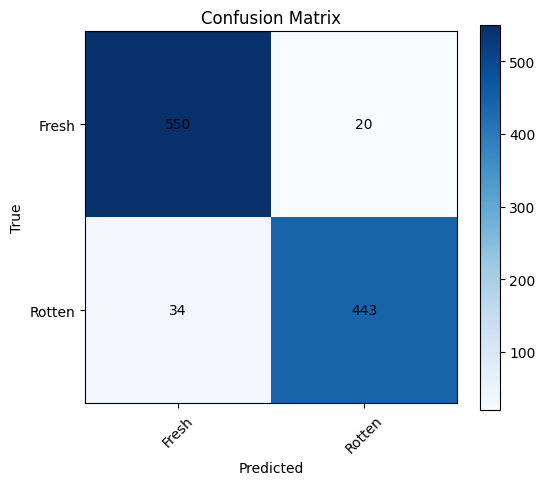

Confusion matrix saved to: /content/drive/MyDrive/Colab Notebooks/DS4002-Project3/OUTPUT/confusion_matrix.png


In [9]:
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
plt.imshow(cm, cmap="Blues")
plt.colorbar()
plt.title("Confusion Matrix")

plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
plt.yticks(np.arange(len(class_names)), class_names)

for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black")

plt.xlabel("Predicted")
plt.ylabel("True")

cm_path = os.path.join(OUTPUT_ROOT, "confusion_matrix.png")
plt.savefig(cm_path, dpi=300, bbox_inches="tight")
plt.show()

print("Confusion matrix saved to:", cm_path)